# Case X.
Lauri Marjanen & Jesse Jyrälä, Team 10<br>
Neural Networks for Machine Learning Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

In [45]:
# Required libraries
import numpy as np
%pylab inline
import os
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.layers import Embedding, Dropout, Conv1D, GlobalAveragePooling1D, Dense

from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical




print(f'Tensorflow version {tf.__version__}')

Populating the interactive namespace from numpy and matplotlib
Tensorflow version 2.7.0


# Data

In [46]:
train = pd.read_csv(os.getcwd() + '/input/drugsComTrain_raw.csv')
test = pd.read_csv(os.getcwd() + '/input/drugsComTest_raw.csv')

In [47]:
%%time

maxFeat = 5000
seqLen = 200

samples = train['review']
tokenizer = Tokenizer(maxFeat)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

wordIndx = tokenizer.word_index
data = pad_sequences(sequences,seqLen)

print("Token count: ", len(wordIndx))
print("Shape: ", data.shape)

Token count:  51429
Shape:  (161297, 200)
Wall time: 29 s


In [48]:
ratings = train['rating'].values
labels = 1.0*(ratings >= 8) + 1.0*(ratings >= 5)
hotLabels = to_categorical(labels)
print("Shape of lables", hotLabels.shape)


Shape of lables (161297, 3)


## MODEL

In [49]:
valSplit = 0.25
N = int(valSplit * data.shape[0])
index = np.arange(data.shape[0])
np.random.shuffle(index)
data = data[index]
hotLabels = hotLabels[index]

trainData = data[:-N]
trainCat = hotLabels[:-N]
valData = data[-N:]
valCat = hotLabels[-N:]

In [50]:
embeddedDing = 100

model = Sequential([
    Embedding(maxFeat +1, embeddedDing),
    Dropout(0.2),
    Conv1D(128,7, padding="valid", activation= "relu", strides=3),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(128,activation="relu"),
    Dense(3,activation="softmax")
])
model.compile(loss = 'categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         500100    
                                                                 
 dropout_8 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         89728     
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                      

In [51]:
EPOCHS = 5
VERBOSE = 1

In [52]:
%%time
hist= model.fit(trainData, trainCat,
                batch_size=128,
                epochs=EPOCHS,
                verbose=VERBOSE,
                validation_data=(valData,valCat)
                )

Epoch 1/5
946/946 [==============================] - 56s 58ms/step - loss: 0.7130 - acc: 0.7134 - val_loss: 0.7169 - val_acc: 0.7175
Epoch 2/5
946/946 [==============================] - 56s 59ms/step - loss: 0.6125 - acc: 0.7563 - val_loss: 0.6024 - val_acc: 0.7589
Epoch 3/5
946/946 [==============================] - 56s 60ms/step - loss: 0.5721 - acc: 0.7716 - val_loss: 0.5879 - val_acc: 0.7671
Epoch 4/5
946/946 [==============================] - 54s 57ms/step - loss: 0.5403 - acc: 0.7848 - val_loss: 0.6163 - val_acc: 0.7570
Epoch 5/5
946/946 [==============================] - 54s 57ms/step - loss: 0.5117 - acc: 0.7978 - val_loss: 0.5981 - val_acc: 0.7716
Wall time: 4min 36s


# Results and Discussion

The following results were achieved ...

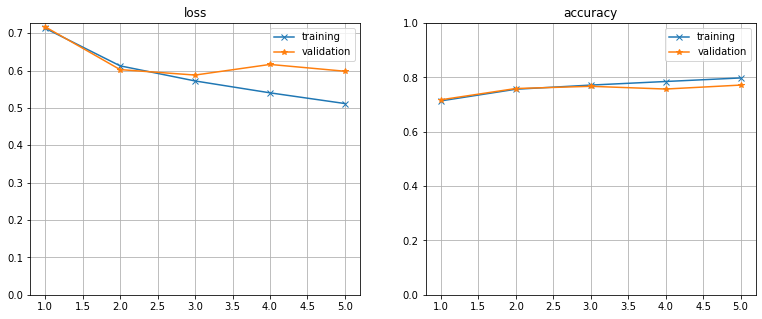

In [58]:
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure, subplot, plot, title, ylim, legend, grid

x_axis = np.arange(len(hist.history['loss'])) + 1


figure(figsize(13,5))
subplot(1,2,1)
plot(x_axis, hist.history['loss'], 'x-', label = 'training')
plot(x_axis, hist.history['val_loss'], '*-', label = 'validation')
title('loss')
ylim(0,)
legend()
grid()


subplot(1,2,2)
plot(x_axis, hist.history['acc'], 'x-', label = 'training')
plot(x_axis, hist.history['val_acc'], '*-', label = 'validation')

title('accuracy')
ylim(0,1.0)
legend()
grid()

In [60]:
from sklearn.metrics import cohen_kappa_score

pred_labels = np.argmax(model.predict(valData),axis=1)
val_labels = np.argmax(valCat, axis = 1)

k = cohen_kappa_score(val_labels,pred_labels)
print("Chohen's kappa linear", k)

k = cohen_kappa_score(val_labels,pred_labels, weights='quadratic')
print("Chohen's kappa quad", k)

Chohen's kappa linear 0.5429166369285099
Chohen's kappa quad 0.6733936199028562


# Conclusions

To summarize we found out that ...